### Fine Tuning BERT model for Sentiment Analysis

##### Goal: To fine tune Google's BERT model by adding a few neural network layers on my own and freezing the actual layers of BERT architecture.

##### Problem Statement: Classifying sentences into POSITIVE and NEGATIVE by using fine-tuned BERT model.

In [1]:
%pip install transformers
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Preparing the dataset

# Imports

import pandas as pd  
import numpy as np
import torch # For Data structures for multi-dimensional tensors.
from transformers import BertTokenizerFast, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from torch import nn 
from torch.utils.data import DataLoader # For efficiently loading and iterating over datasets during model training and evaluation.
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

c:\Users\jonat\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset

df = pd.read_csv('IMDB-Dataset.csv')

In [3]:
# Split the dataset

from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['sentence'], df['label'], 
                                                                    random_state = 2021, test_size = 0.3,
                                                                    stratify = df['label'])



val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2021,
                                                                test_size = 0.5, stratify= temp_labels)





In [4]:
# Load pre-trained BERT model and tokenizer

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

(array([2.4755e+04, 7.4800e+03, 1.9390e+03, 7.0300e+02, 1.1000e+02,
        4.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([   6. ,  252.4,  498.8,  745.2,  991.6, 1238. , 1484.4, 1730.8,
        1977.2, 2223.6, 2470. ]),
 <BarContainer object of 10 artists>)

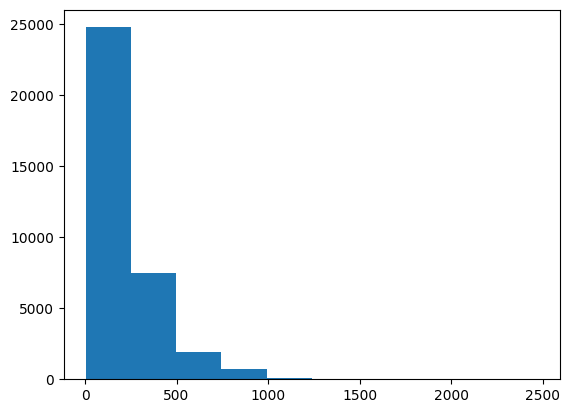

In [5]:
# Deciding the Padding lenght

# If decide to set the padding lenght as the maximum lenght of the text found in the training texts,
# it might leave the training data sparse. On the other hand, taking hte least lenght would in turn lead to loss
# of information. 
# That is why, it is better to find the average lenght and set it as the padding length to trade-off between 2 extremes.

# Plot

train_lens = [len(i.split()) for i in train_text]
plt.hist(train_lens)

In [6]:
# Tokenize the data and encode sequences using the BERT tokenizer.

pad_len = 450


tokens_train = tokenizer.batch_encode_plus(train_text.tolist(),
                                           max_length = pad_len,
                                           padding = 'max_length',
                                           truncation = True)

tokens_val = tokenizer.batch_encode_plus(val_text.tolist(),
                                         max_length = pad_len,
                                         padding = 'max_length',
                                         truncation = True)

tokens_test = tokenizer.batch_encode_plus(test_text.tolist(),
                                          max_length = pad_len,
                                          padding = 'max_length',
                                          truncation = True)



# Since train_labels is a string, we need to create a mapping from the string labels to integers before converting to a PyTorch tensor. 

# Definition of label mapping
label_map = {'positive': 1, 'negative': 0}

# Convert string labels to integers using the label map, then to PyTorch Tensors.
train_seq = torch.tensor(tokens_train['input_ids']) # Converts the input_ids from tokens_train dictionary into a PyTorch tensor.
train_mask = torch.tensor(tokens_train['attention_mask']) # Converts the attention mask from tokens_train dictionary into a PyTorch tensor.
train_y = torch.tensor([label_map[label] for label in train_labels]) # Map strings to integers.

val_seq = torch.tensor(tokens_val['input_ids']) # Same process for validation set.
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor([label_map[label] for label in val_labels])

test_seq = torch.tensor(tokens_test['input_ids']) # Same process for test set.
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor([label_map[label] for label in test_labels])


In [7]:
# Defining the model

# First step is to freeze the BERT pre-trained model, and then add layers.

# Freeze the pretrained layers

for param in bert.parameters():
    param.requires_grad = False

# Defining the new layers

class BERT_architecture(nn.Module):
    
    def __init__(self, bert):
        super(BERT_architecture, self).__init__()
        
        self.bert = bert
        
        # Dropout layer
        self.dropout = nn.Dropout(0.2) # Layer to prevent overfitting.
        
        # relu activation function
        self.relu = nn.ReLU() 
        
        # dense layer   
        self.fc1 = nn.Linear(768, 512)
        
        # Dense layer - Output
        self.fc2 = nn.Linear(512, 2)
        
    # Definition of forward pass
    def forward(self, sent_id, mask):
        
        # Pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)
        
        x = self.relu(x)
        
        x = self.dropout(x)
        
        # Output layer
        x = self.fc2(x)
        
        
        return x

In [8]:
# Add Optimizer to enhance performance

model = BERT_architecture(bert)

optimizer = AdamW(model.parameters(), lr=1e-5)

In [9]:
# Build datasets and dataloaders
# TensorDataset is a PyTorch class that wraps tensors into a single dataset.
# DataLoader is a PyTorch class that provides an iterable over a dataset with support for batching, shuffling, and parallel loading.
# RandomSampler is a PyTorch class that samples elements randomly from a dataset.
# SequentialSampler is a PyTorch class that samples elements sequentially, always in the same order.
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# TensorDataset(input_squences, attention_masks, labels)
train_ds = TensorDataset(train_seq, train_mask, train_y.long())
val_ds = TensorDataset(val_seq, val_mask, val_y.long())
test_ds = TensorDataset(test_seq, test_mask, test_y.long())

BATCH_SIZE = 16

train_dataloader = DataLoader(train_ds, sampler=RandomSampler(train_ds), batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_ds,sampler=SequentialSampler(val_ds), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_ds, sampler=SequentialSampler(test_ds), batch_size=BATCH_SIZE)

In [10]:
# Loss, device and training/eval functions.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()

def train_one_epoch():
    model.train()
    running = 0.0
    
    for step, (ids, mask, labels) in enumerate(train_dataloader):
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
        
        optimizer.zero_grad() # Clear previous gradients.
        logits = model(ids, mask) # head returns logits.
        loss = criterion(logits, labels) # Compute the loss. criterion(output, target)
        loss.backward() # Backpropagate the loss.
        optimizer.step() # Update model parameters based on the computed gradients
        
        running += loss.item()
        
        if step % 50 == 0 and step != 0:
            print(f"Batch {step}/{len(train_dataloader)}. Loss= {running/(step+1):.4f}")
        
    
    return running/len(train_dataloader)
            

In [11]:
# Evaluate function

def evaluate(loader):
    model.eval()
    running = 0.0
    
    all_preds, all_labels = [], []
    
    for ids, mask, labels in loader: 
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
        logits = model(ids, mask)
        loss = criterion(logits, labels)
        running += loss.item()
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())    
    
    return running/len(loader), np.concatenate(all_preds), np.concatenate(all_labels)

In [ ]:
from copy import deepcopy
from sklearn.metrics import accuracy_score

# Unfreeze BERT
for p in model.bert.parameters():
    p.requires_grad = True

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

EPOCHS = 3
best_val_acc = -1.0
best_state = None
patience = 2
bad_epochs = 0

for ep in range(1, EPOCHS+1):
    tr_loss = train_one_epoch()
    val_loss, v_pred, v_true = evaluate(val_dataloader)
    val_acc = accuracy_score(v_true, v_pred)
    print(f"Epoch {ep}: train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, "best_bert_sentiment.pt")
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)


Batch 50/2188. Loss= 0.5856
Batch 100/2188. Loss= 0.4649
Batch 150/2188. Loss= 0.4045
Batch 200/2188. Loss= 0.3683
Batch 250/2188. Loss= 0.3447
Batch 300/2188. Loss= 0.3291
Batch 350/2188. Loss= 0.3145
Batch 400/2188. Loss= 0.3073
Batch 450/2188. Loss= 0.3007
Batch 500/2188. Loss= 0.2945
Batch 550/2188. Loss= 0.2904
Batch 600/2188. Loss= 0.2858
Batch 650/2188. Loss= 0.2807
Batch 700/2188. Loss= 0.2762
Batch 750/2188. Loss= 0.2696
Batch 800/2188. Loss= 0.2658
Batch 850/2188. Loss= 0.2630
